## 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


In [5]:
# Train/Valid/Test ratio
ratios = [.6, .2, .2]

train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print('Train %d / Valid %d/ Test %d samples.'%(train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113/ Test 115 samples.


In [6]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [7]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()
    ]

## 학습 코드 구현
- 모델 구조의 마지막에는 시그모이드를 넣어주어 이진 분류를 위한 준비를 마친다.

In [9]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25,20),
    nn.LeakyReLU(),
    nn.Linear(20,15),
    nn.LeakyReLU(),
    nn.Linear(15,10),
    nn.LeakyReLU(),
    nn.Linear(10,5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid(),
)
model

Sequential(
  (0): Linear(in_features=30, out_features=25, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=25, out_features=20, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=20, out_features=15, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=15, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=5, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=5, out_features=1, bias=True)
  (11): Sigmoid()
)

In [10]:
optimizer = optim.Adam(model.parameters())

In [11]:
n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [12]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch %d : trian loss=%.4e valid_loss=%.4e lowest_loss=%.4e' % (
            i+1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('There is no improvment during last %d epochs'%early_stop)
            break

print('The best validation loss from epoch %d : %.4e' % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10 : trian loss=1.1964e-01 valid_loss=1.0250e-01 lowest_loss=1.5298e-01
Epoch 20 : trian loss=2.7953e-02 valid_loss=1.1721e-01 lowest_loss=8.7403e-02
Epoch 30 : trian loss=1.5071e-02 valid_loss=1.3551e-01 lowest_loss=8.7403e-02
Epoch 40 : trian loss=1.2852e-02 valid_loss=1.4549e-01 lowest_loss=8.7403e-02
Epoch 50 : trian loss=1.0614e-02 valid_loss=1.5272e-01 lowest_loss=8.7403e-02
Epoch 60 : trian loss=8.7601e-03 valid_loss=1.6298e-01 lowest_loss=8.7403e-02
Epoch 70 : trian loss=6.7819e-03 valid_loss=1.7543e-01 lowest_loss=8.7403e-02
Epoch 80 : trian loss=2.5121e-03 valid_loss=1.9860e-01 lowest_loss=8.7403e-02
Epoch 90 : trian loss=1.0585e-03 valid_loss=2.2398e-01 lowest_loss=8.7403e-02
Epoch 100 : trian loss=5.3859e-04 valid_loss=2.4535e-01 lowest_loss=8.7403e-02
Epoch 110 : trian loss=3.3269e-04 valid_loss=2.6145e-01 lowest_loss=8.7403e-02
There is no improvment during last 100 epochs
The best validation loss from epoch 12 : 8.7403e-02


<All keys matched successfully>

## 손실 곡선 확인

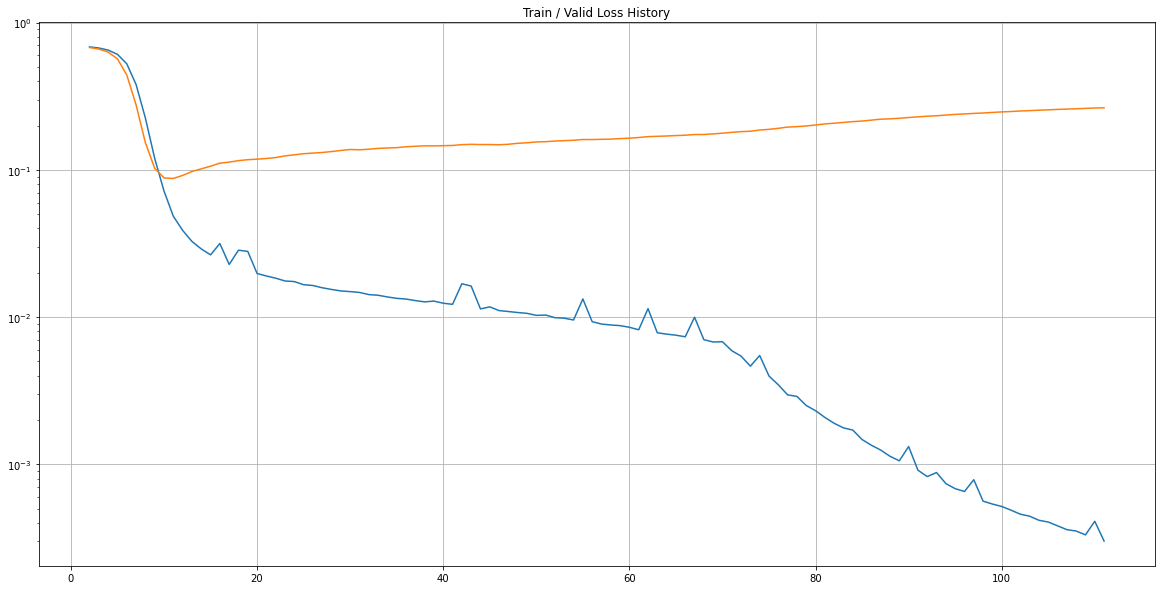

In [13]:
plot_from = 2
 
plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],

)
plt.yscale('log')
plt.show()

## 결과 확인

In [15]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        test_loss += loss

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x:x[1])

print('Train loss : %.4e' % sorted_history[0][0])
print('valid loss : %.4e' % sorted_history[0][1])
print('Test loss: %.4e' % test_loss)

Train loss : 4.8430e-02
valid loss : 8.7403e-02
Test loss: 1.1444e-01


In [17]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy : %.4f' % (correct_cnt / total_cnt))

Test Accuracy : 0.9652


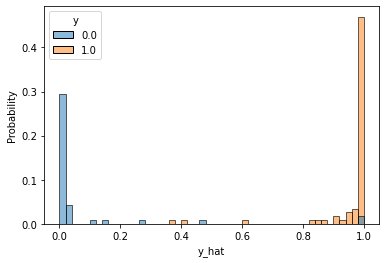

In [18]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=['y','y_hat'])
sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df.values[:,0], df.values[:,-1])

0.9853968253968254

In [ ]:
s